# Importación de Librerias

In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential


# Objetivo

Diseñar la arquitectura de una CNN para la predicción de imagenes que contegan nubes en su interior, tomadas desde una perpestiva aerea.

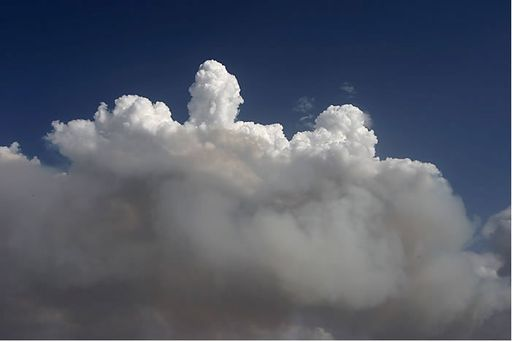

# Carga de Datos



In [2]:
# Montar Google Drive
drive.mount("/content/drive", force_remount=True)

# Definir las rutas de las carpetas
cloud_folder = '/content/drive/MyDrive/Modulo4_CDD_Student/Redes neuronales/cloud'
not_cloud_folder = '/content/drive/MyDrive/Modulo4_CDD_Student/Redes neuronales/not_cloud'

# Listas para almacenar las imágenes
cloud_images = []
not_cloud_images = []

Mounted at /content/drive


https://www.kaggle.com/datasets/kishor1123/cloud-satelite-maxar-dataset/data

Se cargaron 1342 imágenes de la carpeta 'cloud'.
Se cargaron 1134 imágenes de la carpeta 'not_cloud'.

--- Mostrando imágenes de carpeta 'cloud' ---


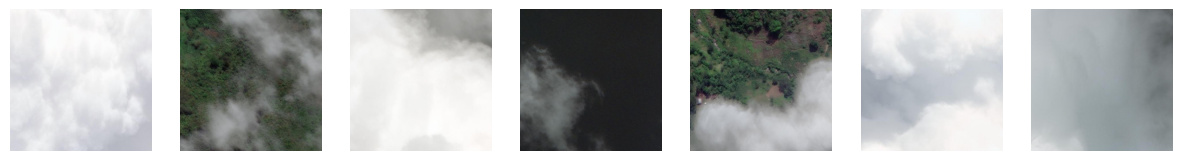


--- Mostrando imágenes de carpeta 'not_cloud' ---


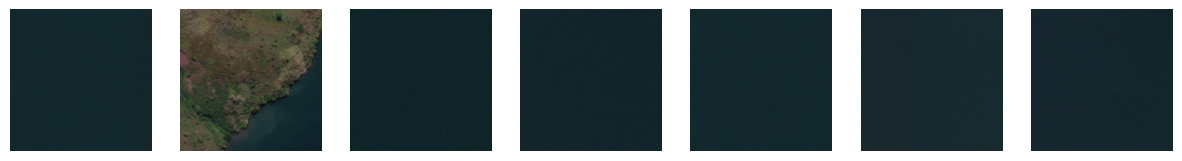

In [3]:
# Función para cargar imágenes en una lista
def load_images_from_folder(folder_path):
    images = []
    if not os.path.exists(folder_path):
        print(f"La carpeta {folder_path} no existe.")
        return images

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No se encontraron imágenes en {folder_path}.")
        return images

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        images.append(img)
    return images

# Cargar imágenes en las listas
cloud_images = load_images_from_folder(cloud_folder)
not_cloud_images = load_images_from_folder(not_cloud_folder)

# Mostrar información
print(f"Se cargaron {len(cloud_images)} imágenes de la carpeta 'cloud'.")
print(f"Se cargaron {len(not_cloud_images)} imágenes de la carpeta 'not_cloud'.")

# Función para mostrar imágenes de una lista
def show_images_from_list(images, title, num_images=7):
    if not images:
        print(f"No hay imágenes para mostrar en {title}.")
        return
    print(f"\n--- Mostrando imágenes de {title} ---")
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(images[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Mostrar ejemplos
show_images_from_list(cloud_images, "carpeta 'cloud'")
show_images_from_list(not_cloud_images, "carpeta 'not_cloud'")

# Aplicación de filtros al conjunto de imagenes

=== Imágenes de 'cloud' con filtros aplicados ===


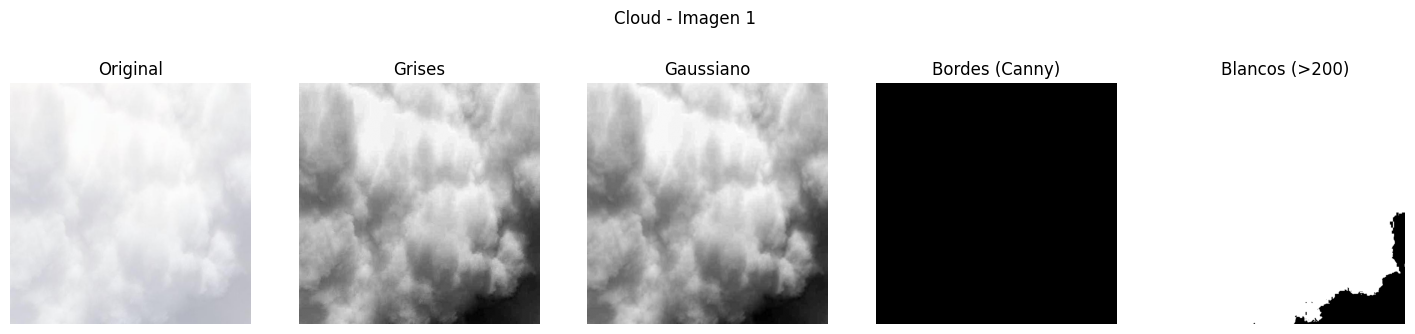

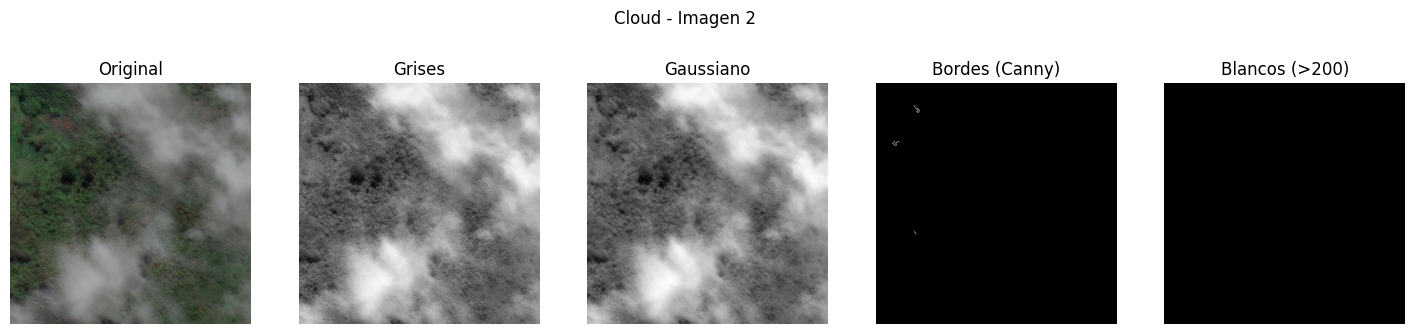

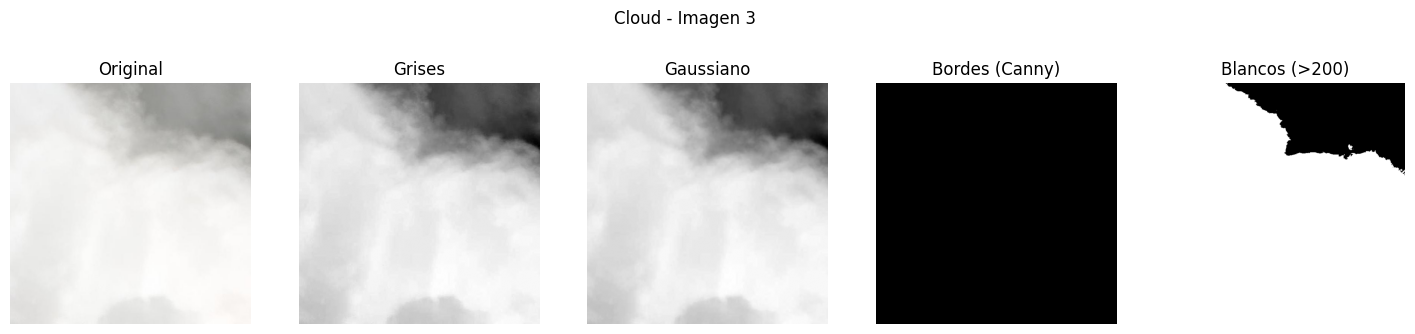

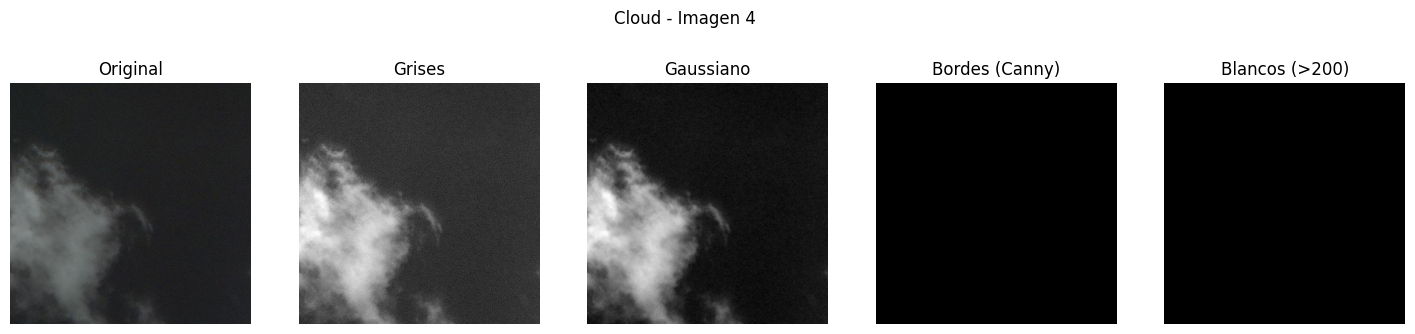

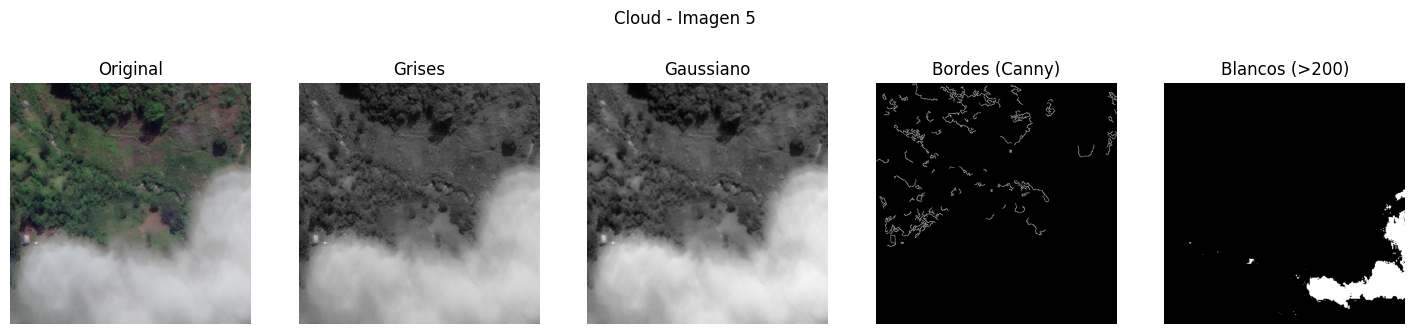


=== Imágenes de 'not_cloud' con filtros aplicados ===


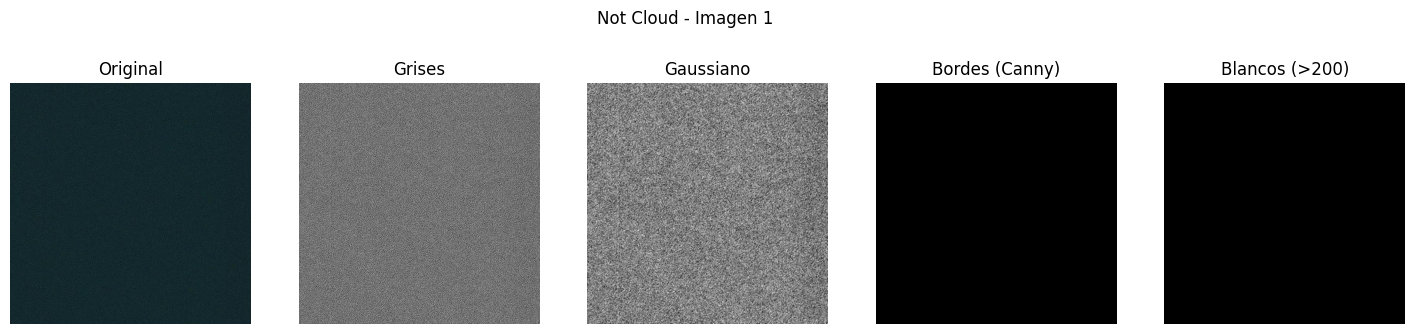

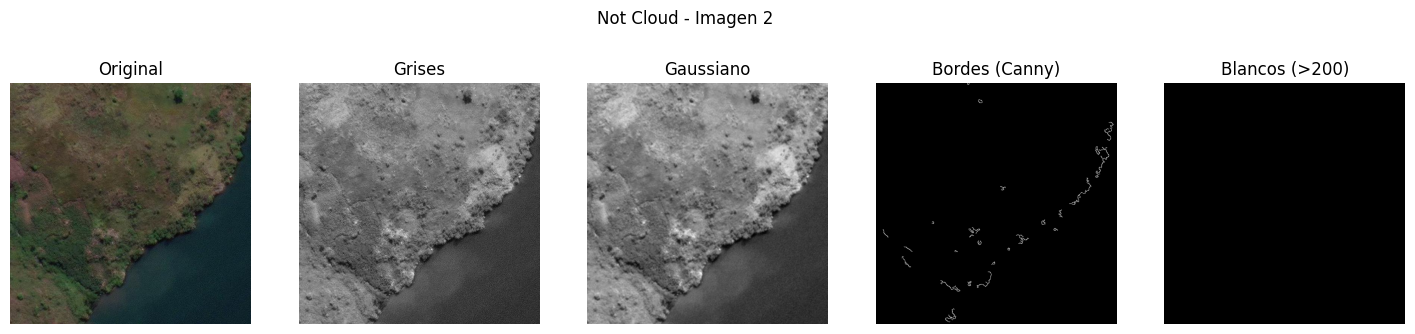

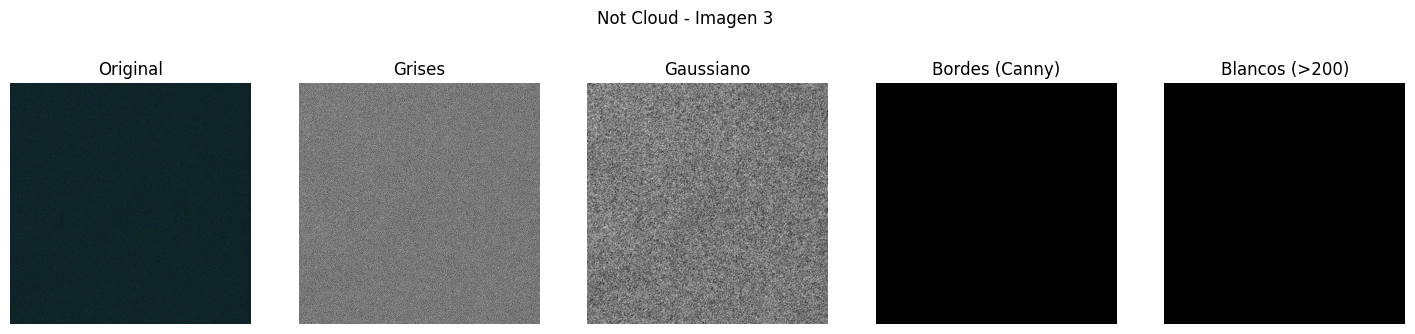

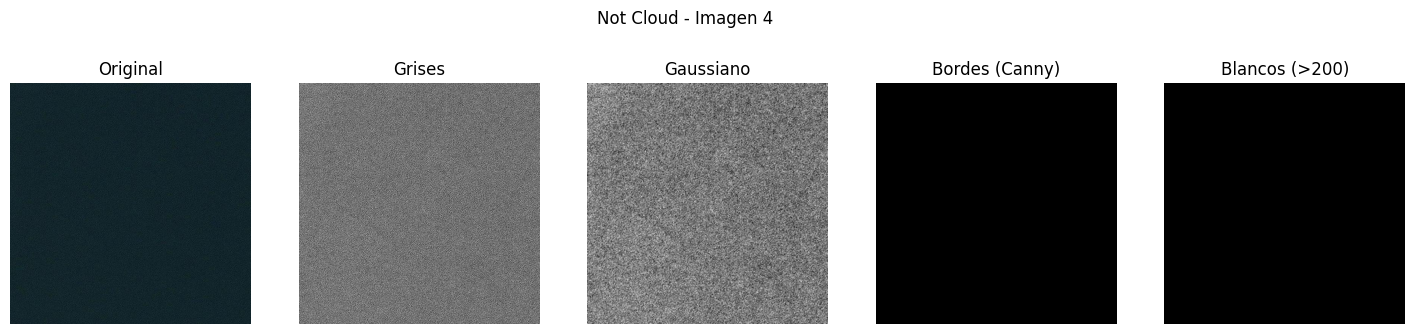

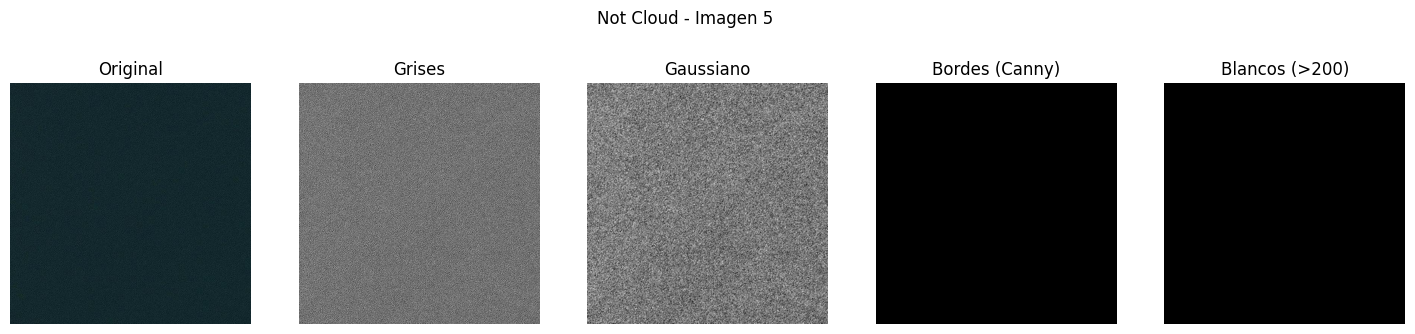

In [4]:


# Función para aplicar filtros (ahora incluye segmentación de blancos)
def apply_filters(img, white_threshold=200):
    # Convertir a escala de grises (si la imagen es a color)
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Aplicar filtro Gaussiano
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detector de bordes (Canny)
    edges = cv2.Canny(blurred, 50, 150)

    # Segmentación de píxeles blancos
    white_mask = gray > white_threshold  # Máscara binaria (1=blanco, 0=no blanco)

    return gray, blurred, edges, white_mask

# Función para mostrar imágenes con filtros aplicados (actualizada)
def display_filtered_images(images, title, num_images=5):
    if not images:
        print(f"No hay imágenes para mostrar en {title}.")
        return

    for i, img in enumerate(images[:num_images]):
        # Aplicar filtros
        gray, blurred, edges, white_mask = apply_filters(img)

        # Mostrar resultados (ahora con 5 subplots)
        plt.figure(figsize=(18, 4))

        # Imagen original
        plt.subplot(1, 5, 1)
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("Original")

        # Escala de grises
        plt.subplot(1, 5, 2)
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        plt.title("Grises")

        # Filtro Gaussiano
        plt.subplot(1, 5, 3)
        plt.imshow(blurred, cmap='gray')
        plt.axis('off')
        plt.title("Gaussiano")

        # Bordes (Canny)
        plt.subplot(1, 5, 4)
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.title("Bordes (Canny)")

        # Segmentación de blancos
        plt.subplot(1, 5, 5)
        plt.imshow(white_mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Blancos (>{white_threshold})")

        plt.suptitle(f"{title} - Imagen {i+1}")
        plt.show()

# Mostrar imágenes preprocesadas
white_threshold = 200  # Ajustable según necesidad
print("=== Imágenes de 'cloud' con filtros aplicados ===")
display_filtered_images(cloud_images, "Cloud")

print("\n=== Imágenes de 'not_cloud' con filtros aplicados ===")
display_filtered_images(not_cloud_images, "Not Cloud")

Las imagenes pasaron primero por un filtro de escala de grises, posterioermente las imagenes fueron pasarón por un filtro Gausiano.
Esta elección se tomo debido a que el primer filtro reduce la dimensionalidad y enfoca las texturas, y el segundo filtro suaviza imágenes y reduce ruido (útil si hay artefactos o grano).

# Elección de imagenes con filtros

In [5]:
# Listas para imágenes procesadas
cloud_processed = []
not_cloud_processed = []

for img in cloud_images:
    gray, blurred, edges, white_mask = apply_filters(img)
    cloud_processed.append({ 'gausiano': blurred, "target":1})

for img in not_cloud_images:
    gray, blurred, edges, white_masks = apply_filters(img)
    not_cloud_processed.append({'gausiano': blurred,"target":0})

# Creación de un Data Frame

In [6]:
df_cloud = pd.DataFrame(cloud_processed)
df_not_cloud = pd.DataFrame(not_cloud_processed)

df_final = pd.concat([df_cloud, df_not_cloud], ignore_index=True)


print(df_final.head())
print(df_final.shape)


                                            gausiano  target
0  [[247, 247, 247, 247, 247, 247, 247, 247, 247,...       1
1  [[46, 45, 43, 43, 46, 50, 53, 53, 51, 49, 43, ...       1
2  [[238, 238, 238, 238, 238, 238, 238, 238, 238,...       1
3  [[32, 32, 32, 33, 34, 34, 33, 33, 33, 33, 32, ...       1
4  [[81, 80, 79, 81, 83, 81, 72, 60, 53, 54, 63, ...       1
(2476, 2)


# Conjunto de Entrenamiento y Prueba

In [7]:
# Separar características (X) y etiquetas (y)
X = df_final['gausiano'].tolist()
y = df_final['target']

X = np.array(X)

# Redimensionar a un tamaño común
X = np.array([cv2.resize(img, (100, 100)) for img in X])

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=47,
)

# Preprocesamiento de datos

In [8]:
# Normalización: Escalar los valores de píxeles al rango [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Añadir dimensión de canal
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Verificar las formas de los conjuntos
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

# Proporción de clases en y_train e y_test
print("\nDistribución de clases en y_train:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribución de clases en y_test:")
print(pd.Series(y_test).value_counts(normalize=True))

Forma de X_train: (1980, 100, 100, 1)
Forma de X_test: (496, 100, 100, 1)
Forma de y_train: (1980,)
Forma de y_test: (496,)

Distribución de clases en y_train:
target
1    0.538889
0    0.461111
Name: proportion, dtype: float64

Distribución de clases en y_test:
target
1    0.554435
0    0.445565
Name: proportion, dtype: float64


# Frecuencia de las clases

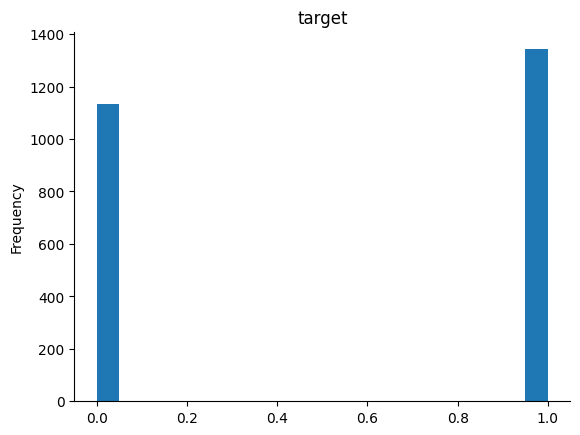

In [9]:
df_final['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Arquitectura de la CNN

In [10]:
model = Sequential([
    # Capa convolucional 1
    Conv2D(32, (3, 3), activation='sigmoid', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),

    # Capa convolucional 2
    Conv2D(64, (3, 3), activation='sigmoid'),
    MaxPooling2D((2, 2)),

    # Capa convolucional 3
    Conv2D(128, (3, 3), activation='sigmoid'),
    MaxPooling2D((2, 2)),

    # Aplanar la salida para conectarla a capas densas
    Flatten(),

    # Capa densa 1
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularización para evitar overfitting

    # Capa de salida (clasificación binaria)
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Resumen del modelo

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,329 (6.60 MB)

 Trainable params: 1,731,329 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

# Copilación del Modelo

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del Modelo

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 666ms/step - accuracy: 0.4997 - loss: 1.5473 - val_accuracy: 0.5544 - val_loss: 0.6894
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 653ms/step - accuracy: 0.5531 - loss: 0.6894 - val_accuracy: 0.5544 - val_loss: 0.6841
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 652ms/step - accuracy: 0.5388 - loss: 0.6827 - val_accuracy: 0.5544 - val_loss: 0.6262
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 799ms/step - accuracy: 0.5453 - loss: 0.6009 - val_accuracy: 0.6431 - val_loss: 0.4075
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 700ms/step - accuracy: 0.8225 - loss: 0.3865 - val_accuracy: 0.9597 - val_loss: 0.3328
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 79s 644ms/step - accuracy: 0.9532 - loss: 0.3374 - val_accuracy: 0.9617 - val_loss: 0.3004
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 45s 708ms/step - accuracy: 0.9712 - loss: 0.2945 - val_accuracy: 0.9637 - val_loss: 0.2833
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 609ms/step - accuracy: 0.9723 - loss: 0.2773 - val_accu

In [14]:
# Evaluar el modelo en los datos de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nPrecisión en datos de prueba: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9551 - loss: 0.2563

Precisión en datos de prueba: 0.9657


# Gráficos durante el entrenamiento


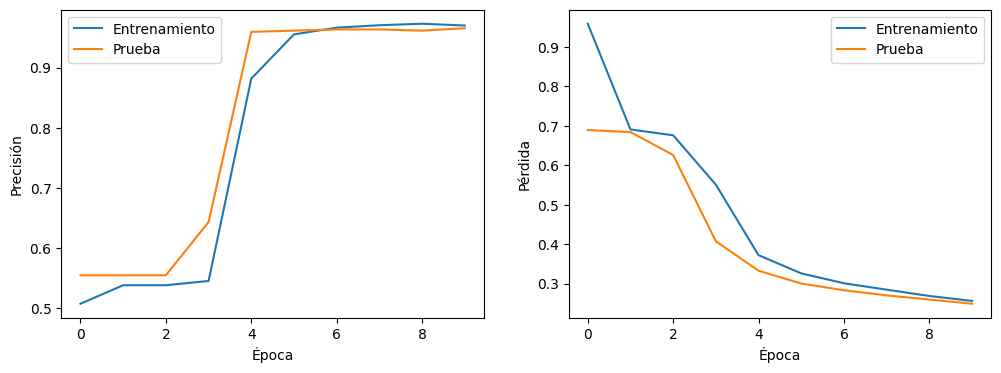

In [15]:
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Prueba')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Predicciones del conjunto de prueba

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


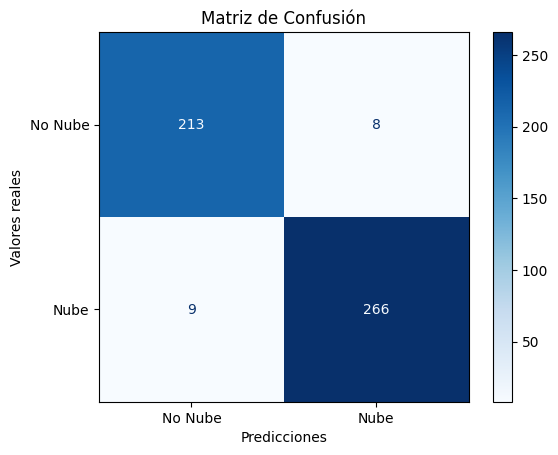

In [16]:

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convertir probabilidades a clases binarias (0 o 1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Nube", "Nube"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()

# Métricas de evaluación

In [17]:
from sklearn.metrics import classification_report
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=["No Nube", "Nube"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

     No Nube       0.96      0.96      0.96       221
        Nube       0.97      0.97      0.97       275

    accuracy                           0.97       496
   macro avg       0.97      0.97      0.97       496
weighted avg       0.97      0.97      0.97       496



# Ejemplos de predicciones

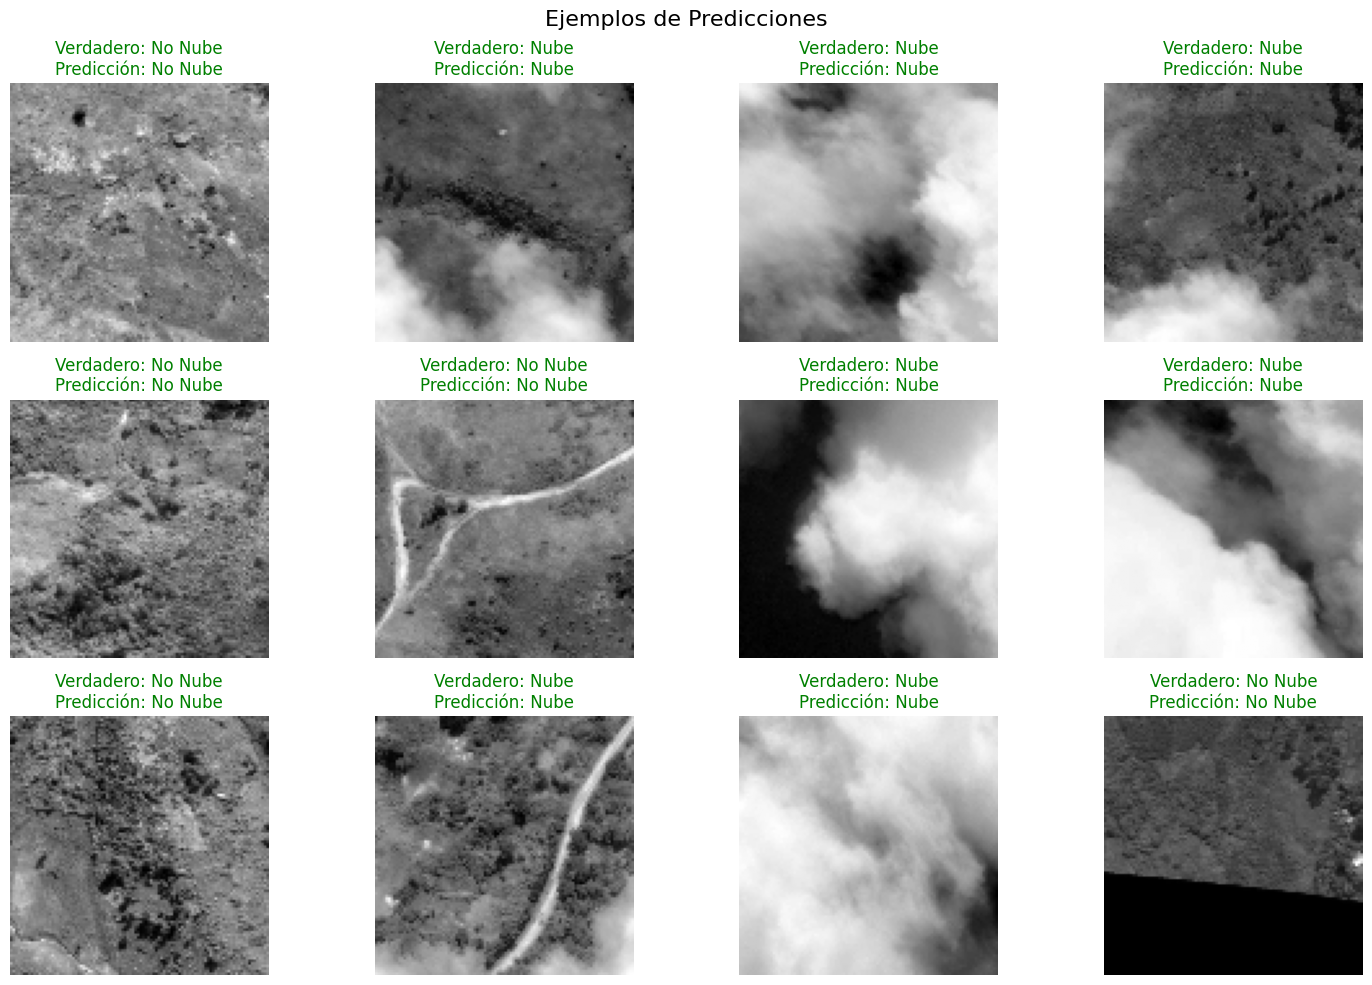

In [18]:
indices = np.random.choice(range(len(X_test)), 12, replace=False)
plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    plt.subplot(3, 4, i + 1)
    img = X_test[idx].reshape(100, 100)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Etiqueta verdadera vs. predicción
    true_label = "Nube" if y_test.iloc[idx] == 1 else "No Nube"
    pred_label = "Nube" if y_pred_classes[idx] == 1 else "No Nube"
    plt.title(f"Verdadero: {true_label}\nPredicción: {pred_label}", color='green' if true_label == pred_label else 'red')

plt.suptitle("Ejemplos de Predicciones", fontsize=16)
plt.tight_layout()
plt.show()

# Conclusión

El modelo propuesto función de manera correcta, sin embargo tiene imagenes particulares las cuales no logra clasificar de buena manera. Por lo tanto, se sugiere hacer futuras mejoras para obtener un mejor desempeño:
* Ampliar la variedad de filtros en las imagenes
* Aumentar el número de capas convulsionales
* Utilizar otras funciones de activación